In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import matthews_corrcoef,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-csv/train (5).csv
/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/approved/credit_risk_dataset.csv


In [2]:
train_csv='/kaggle/input/playground-series-s4e10/train.csv'
train_csv2='/kaggle/input/approved/credit_risk_dataset.csv'
test_csv='/kaggle/input/playground-series-s4e10/test.csv'


In [3]:
train_csv=pd.read_csv(train_csv,nrows=20000,index_col=0)
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,27,60000,RENT,4.0,EDUCATION,A,10000,7.51,0.17,N,8,0
19996,25,51000,MORTGAGE,3.0,EDUCATION,E,16750,16.40,0.33,Y,4,0
19997,28,48000,MORTGAGE,1.0,MEDICAL,A,4800,5.42,0.10,N,7,0


In [4]:
train_cv2=pd.read_csv(train_csv2)
train_cv2

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [5]:
print(type(train_csv2))

<class 'str'>


In [6]:
train_csv=pd.concat([train_csv,train_cv2],axis=0)

In [7]:
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [8]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  52581 non-null  int64  
 1   person_income               52581 non-null  int64  
 2   person_home_ownership       52581 non-null  object 
 3   person_emp_length           51686 non-null  float64
 4   loan_intent                 52581 non-null  object 
 5   loan_grade                  52581 non-null  object 
 6   loan_amnt                   52581 non-null  int64  
 7   loan_int_rate               49465 non-null  float64
 8   loan_percent_income         52581 non-null  float64
 9   cb_person_default_on_file   52581 non-null  object 
 10  cb_person_cred_hist_length  52581 non-null  int64  
 11  loan_status                 52581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.2+ MB


In [9]:
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52581.000000,5.258100e+04,51686.000000,52581.000000,49465.000000,52581.000000,52581.000000,52581.000000
mean,27.640288,6.533759e+04,4.741922,9453.660105,10.885107,0.166157,5.792815,0.190620
std,6.217896,5.479029e+04,4.040399,6045.883032,3.162867,0.101380,4.038082,0.392794
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.220000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
for i in train_csv:
    print(i)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status


In [11]:
def seperation_func(data):
    cont_var=[]
    cat_var=[]
    for i in data.columns:
        if data[i].dtype=='int64'or data[i].dtype=='float64':
            cont_var.append(i)
        else:
            cat_var.append(i)
    return cont_var,cat_var    

In [12]:
cont_var,cat_var=seperation_func(train_csv)

In [13]:
cont_var

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_status']

In [14]:
def plotdist(data,cont):
    for i in cont:
        fig,ax=plt.subplots(1,2,figsize=(10,9))
        sns.histplot(data[i],bins='doane',ax=ax[0])
        ax[0].set_title('Histogram')
        ax[0].set_xlabel(f'{i}')
        ax[0].set_ylabel('count')
        sns.violinplot(data,x=data[i],ax=ax[1])
        ax[1].set_xlabel(f'{i}')
        ax[1].set_title('Voilinplot')
        plt.tight_layout()
        plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


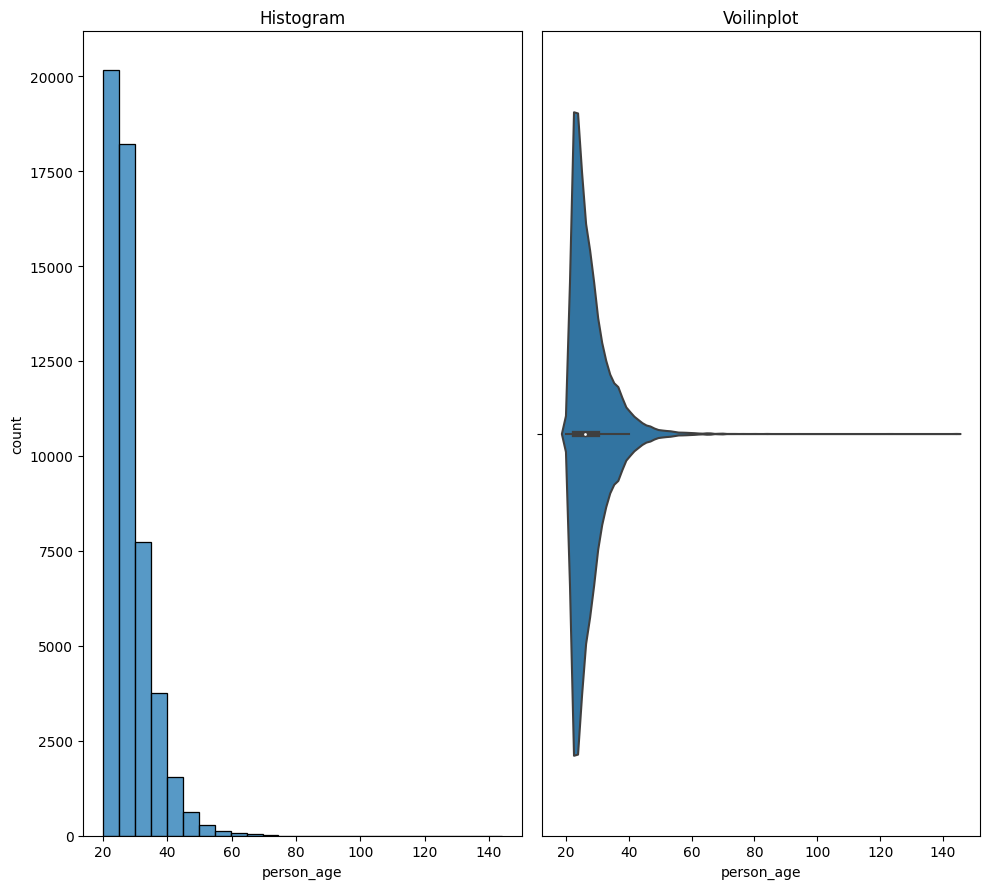

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


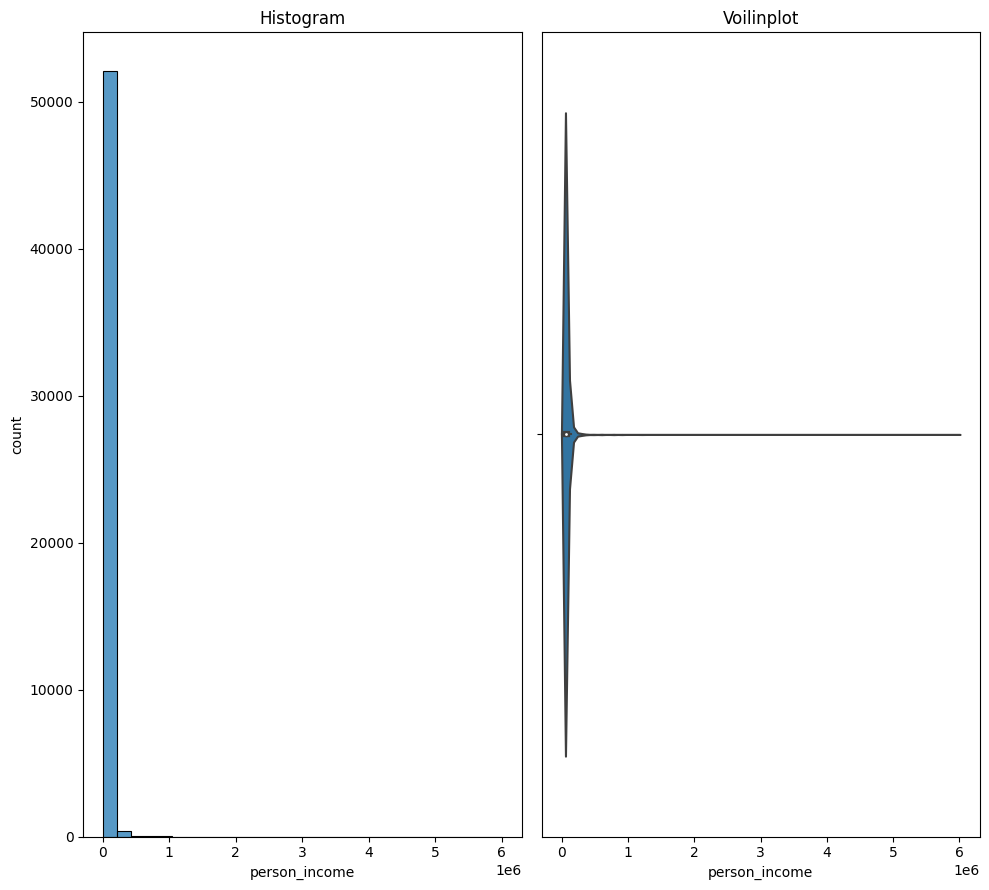

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


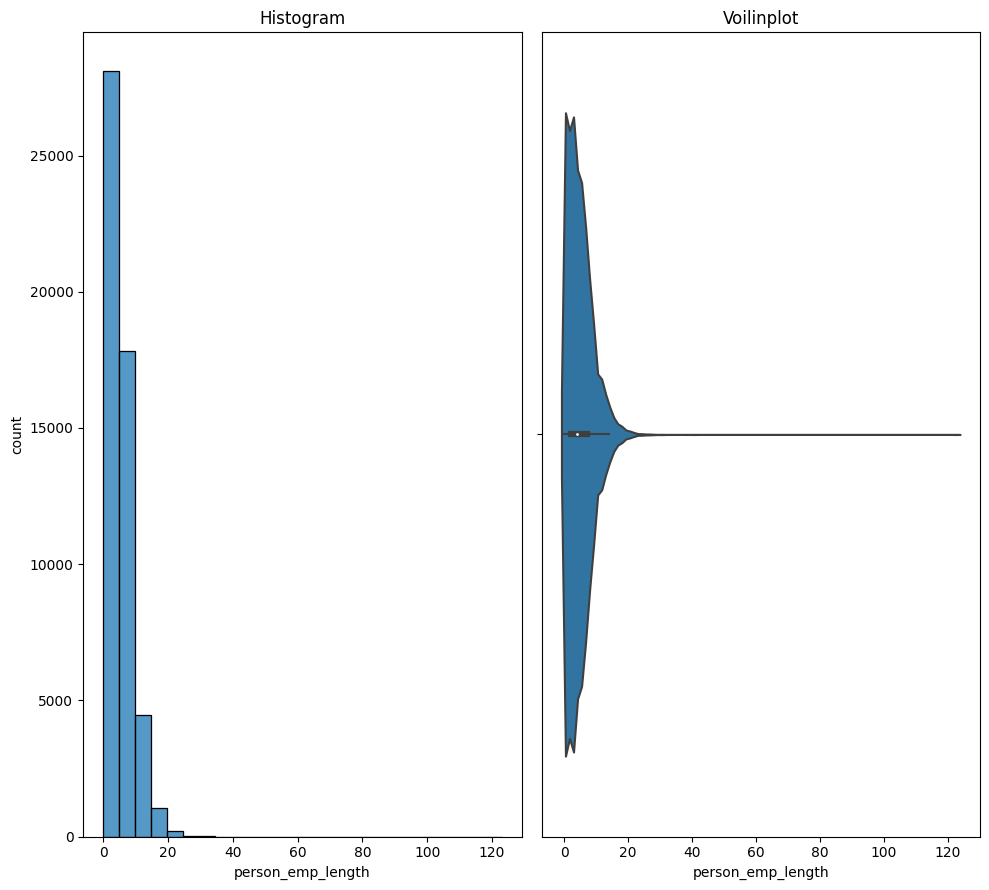

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


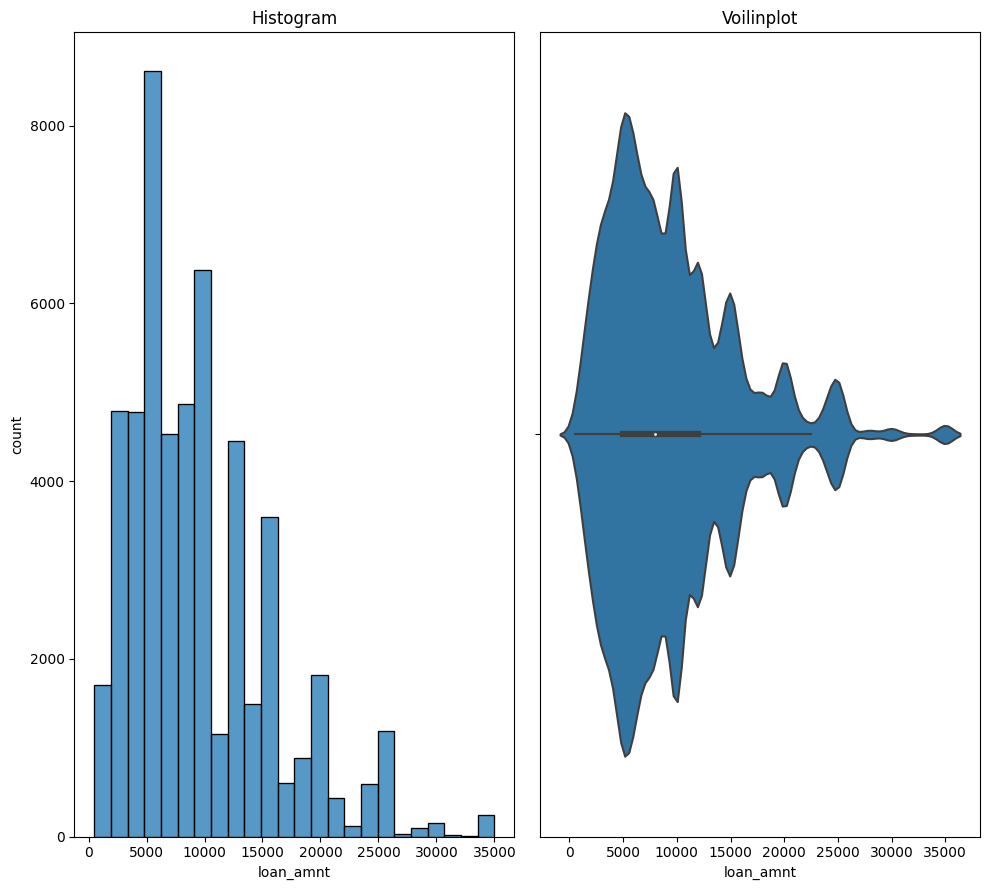

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


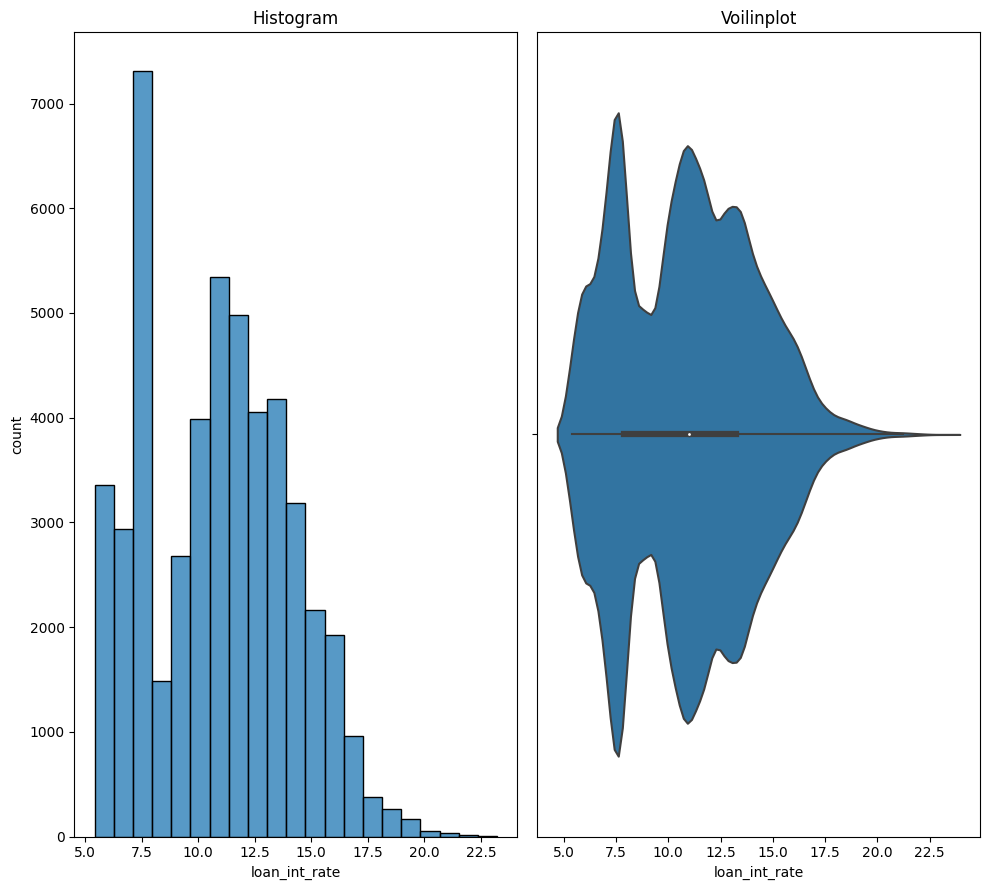

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


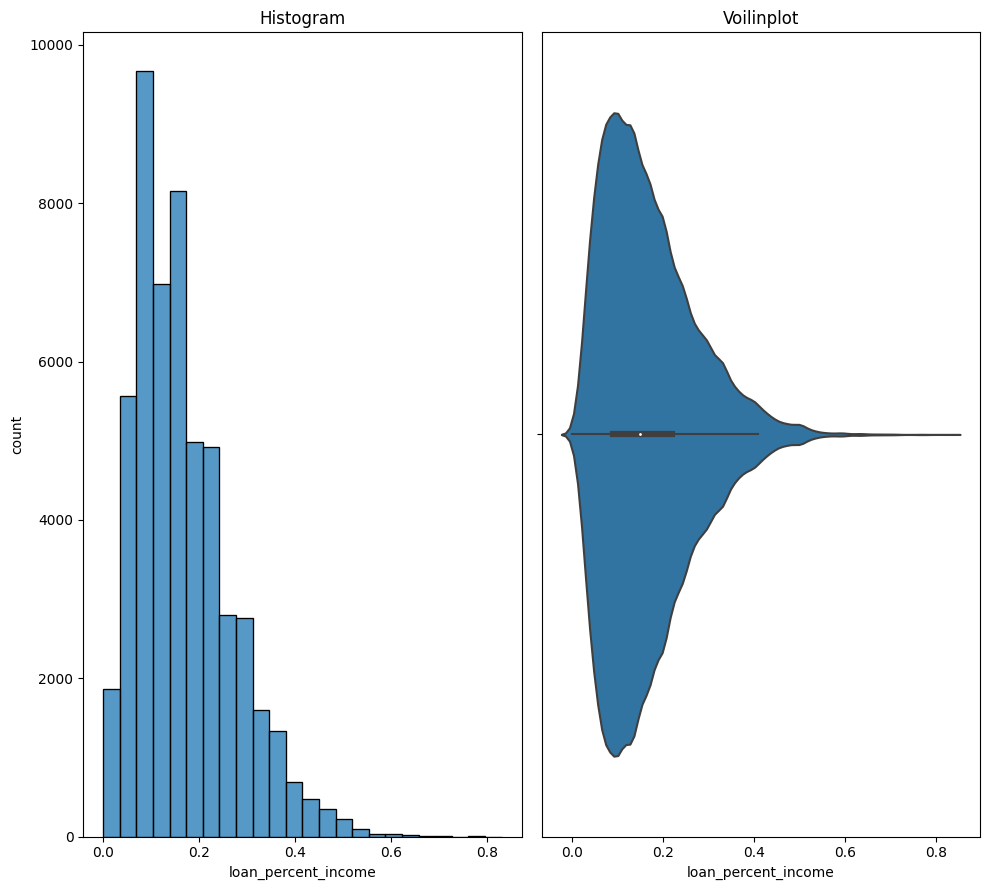

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


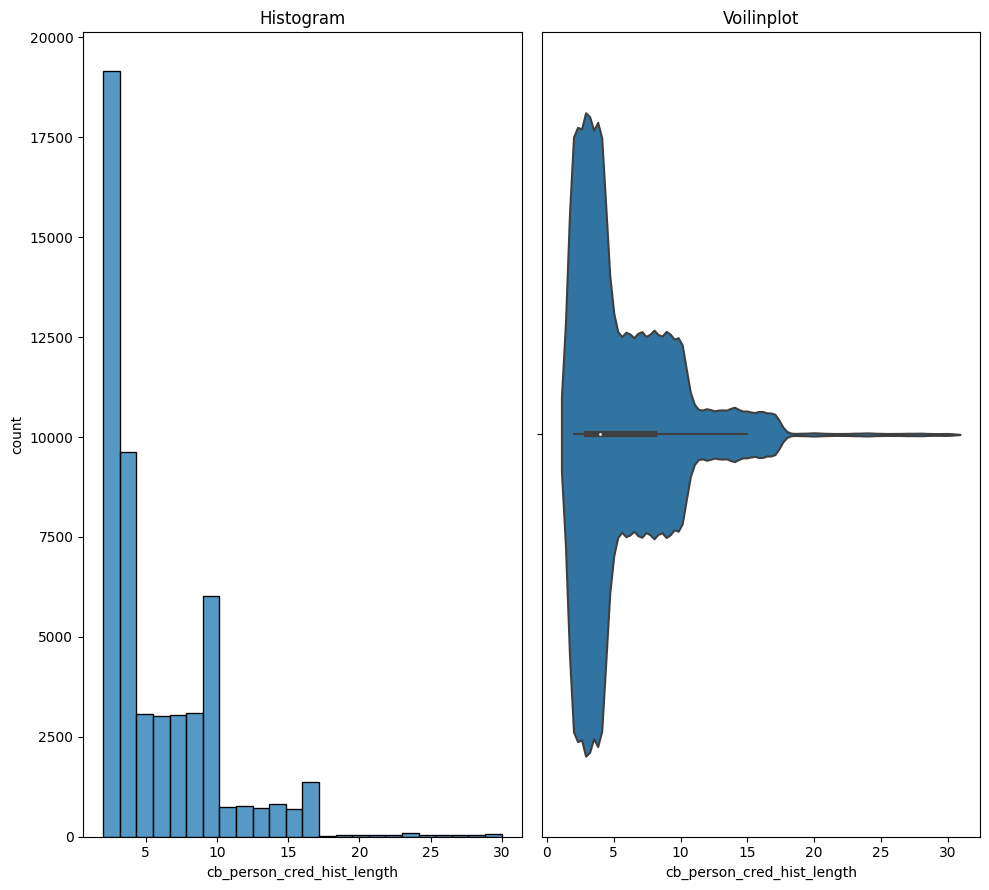

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


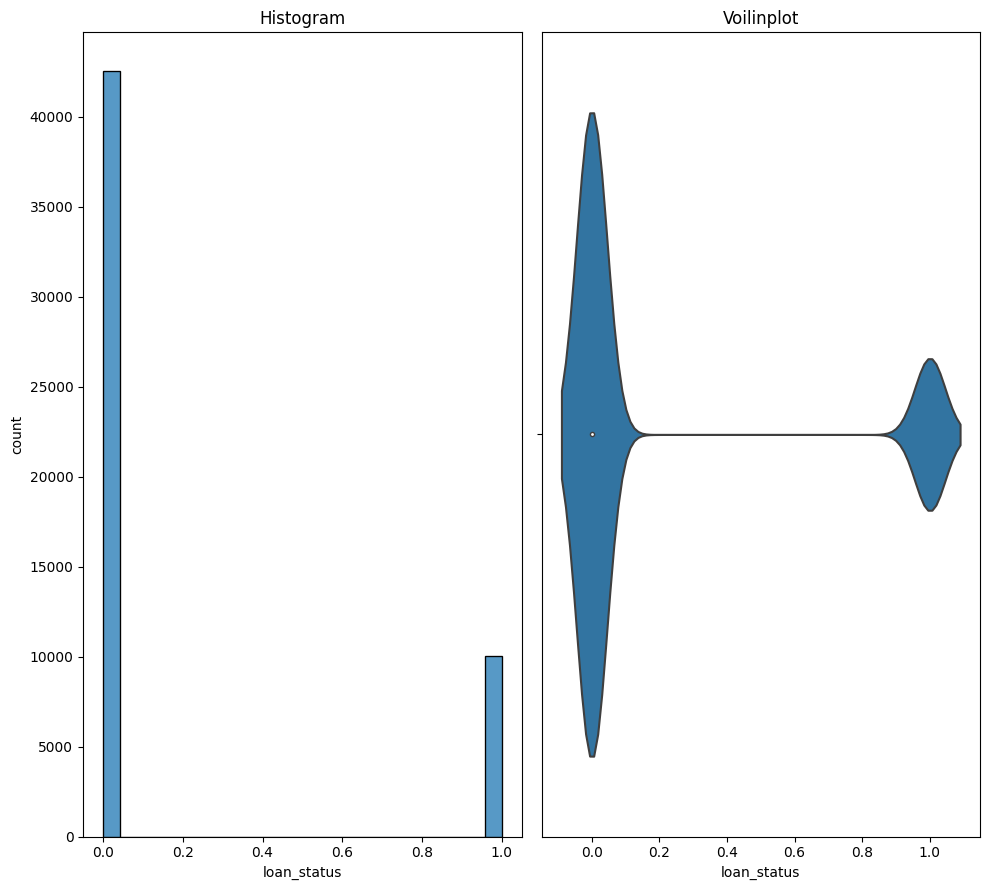

In [15]:
plotdist(train_csv,cont_var)

In [16]:
copy_data=train_csv.copy(deep=True)

## Checking Imbalance Dataset

([<matplotlib.patches.Wedge at 0x792f310d7490>,
 [Text(-0.9085822474887384, 0.6200631415818175, '0'),
  Text(0.9085822474887381, -0.620063141581818, '1')],
 [Text(-0.4955903168120391, 0.3382162590446277, '80.9%'),
  Text(0.4955903168120389, -0.338216259044628, '19.1%')])

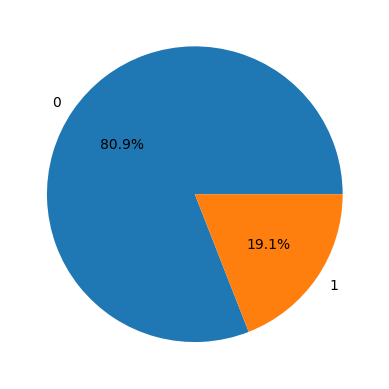

In [17]:
count_class=train_csv['loan_status'].value_counts()
plt.pie(labels=[0,1],x=count_class,autopct='%1.1f%%' )

In [18]:
print(len(train_csv['person_age']>40))

52581


In [19]:
train_csv['person_income']=np.log(train_csv['person_income']+1)
train_csv['loan_amnt']=np.log(train_csv['loan_amnt']+1)

In [20]:
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52581.000000,52581.000000,51686.000000,52581.000000,49465.000000,52581.000000,52581.000000,52581.000000
mean,27.640288,10.937362,4.741922,8.942502,10.885107,0.166157,5.792815,0.190620
std,6.217896,0.527667,4.040399,0.685582,3.162867,0.101380,4.038082,0.392794
min,20.000000,8.294300,0.000000,6.216606,5.420000,0.000000,2.000000,0.000000
25%,23.000000,10.596660,2.000000,8.517393,7.880000,0.090000,3.000000,0.000000
50%,26.000000,10.933125,4.000000,8.987322,10.990000,0.150000,4.000000,0.000000
75%,30.000000,11.264477,7.000000,9.392745,13.220000,0.220000,8.000000,0.000000
max,144.000000,15.607270,123.000000,10.463132,23.220000,0.830000,30.000000,1.000000


In [21]:
def removeoutliers(data,cont):
    q1=data[cont].quantile(0.25)
    q3=data[cont].quantile(0.75)
    IQR=q3-q1
    lower_bound=q1-1.5*IQR
    upper_bound=q3+4.0*IQR
    filtered_data=data[cont].where((data[cont]>lower_bound)&(data[cont]<upper_bound),other=np.nan)
    return filtered_data

In [22]:
for i in cont_var:
    if i=='loan_status':
        continue
    train_csv[i]=removeoutliers(train_csv,i)

In [23]:
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52413.000000,52116.000000,51661.000000,51852.000000,49465.000000,52576.000000,52485.0000,52581.000000
mean,27.517925,10.950152,4.726002,8.970254,10.885107,0.166099,5.7505,0.190620
std,5.787748,0.505922,3.936253,0.648763,3.162867,0.101206,3.9184,0.392794
min,20.000000,9.602450,0.000000,7.208600,5.420000,0.000000,2.0000,0.000000
25%,23.000000,10.596660,2.000000,8.517393,7.880000,0.090000,3.0000,0.000000
50%,26.000000,10.937152,4.000000,8.987322,10.990000,0.150000,4.0000,0.000000
75%,30.000000,11.267038,7.000000,9.392745,13.220000,0.220000,8.0000,0.000000
max,57.000000,13.762111,26.000000,10.463132,23.220000,0.720000,27.0000,1.000000


In [24]:
train_csv[cont_var]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,0
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,0
2,29.0,10.268165,8.0,8.699681,8.90,0.21,10.0,0
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,0
4,22.0,11.002117,2.0,8.699681,6.92,0.10,3.0,0
...,...,...,...,...,...,...,...,...
32576,57.0,10.878066,1.0,8.665786,13.16,0.11,NaN,0
32577,54.0,11.695255,4.0,9.777130,7.49,0.15,19.0,0
32578,NaN,11.238502,3.0,10.463132,10.99,0.46,NaN,1
32579,56.0,11.918397,5.0,9.615872,11.48,0.10,26.0,0


In [25]:
train_csv.dropna(inplace=True)

In [26]:
print(train_csv.shape)
train_csv.describe()

(47473, 12)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000
mean,27.495166,10.959059,4.747793,8.979274,10.892374,0.166365,5.710699,0.183388
std,5.702169,0.499367,3.928947,0.643150,3.154922,0.099126,3.818975,0.386989
min,20.000000,9.602450,0.000000,7.208600,5.420000,0.000000,2.000000,0.000000
25%,23.000000,10.596660,2.000000,8.517393,7.880000,0.090000,3.000000,0.000000
50%,26.000000,10.950824,4.000000,8.987322,10.990000,0.150000,4.000000,0.000000
75%,30.000000,11.277216,7.000000,9.392745,13.220000,0.220000,8.000000,0.000000
max,57.000000,13.762111,26.000000,10.463132,23.220000,0.720000,27.000000,1.000000


In [27]:
for i in cat_var:
    print(train_csv[i].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']
['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
['B' 'C' 'A' 'D' 'E' 'F' 'G']
['N' 'Y']


In [28]:
train_csv=pd.get_dummies(train_csv)
train_csv

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,0,False,False,...,False,False,True,False,False,False,False,False,True,False
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,0,False,False,...,False,False,False,True,False,False,False,False,True,False
2,29.0,10.268165,8.0,8.699681,8.90,0.21,10.0,0,False,False,...,False,True,False,False,False,False,False,False,True,False
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,0,False,False,...,True,False,True,False,False,False,False,False,True,False
4,22.0,11.002117,2.0,8.699681,6.92,0.10,3.0,0,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32573,56.0,11.407576,0.0,8.881975,6.17,0.08,19.0,0,True,False,...,False,True,False,False,False,False,False,False,True,False
32574,52.0,11.082219,4.0,9.903538,15.58,0.31,19.0,1,False,False,...,False,False,False,False,True,False,False,False,False,True
32575,52.0,11.074436,0.0,8.517393,11.26,0.08,20.0,0,False,False,...,False,False,True,False,False,False,False,False,True,False
32577,54.0,11.695255,4.0,9.777130,7.49,0.15,19.0,0,True,False,...,False,True,False,False,False,False,False,False,True,False


In [29]:
from sklearn.cluster import KMeans

In [30]:
def kmeans_featureGrouping(data,n_clusters,col,is_train=True,k_scaled=None,k_meansd=None):
    feature=data[col].values.reshape(-1,1)
    k_scale=RobustScaler()
    if is_train==True:
        feature=k_scale.fit_transform(feature)
        kmeans=KMeans(random_state=42,n_clusters=n_clusters)
        cluster=kmeans.fit_predict(feature)
        return cluster,k_scale,kmeans
    else:
        feature=k_scaled.transform(feature)
        cluster=k_meansd.predict(feature)
        
        return cluster
        
        
    

In [31]:
cluster_age,scale_age,kmeans_age=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='person_age',is_train=True)
print(cluster_age[:10])

[1 0 2 2 0 0 0 0 1 2]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
train_csv['cluster_age']=cluster_age
train_csv

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,cluster_age
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,0,False,False,...,False,True,False,False,False,False,False,True,False,1
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,0,False,False,...,False,False,True,False,False,False,False,True,False,0
2,29.0,10.268165,8.0,8.699681,8.90,0.21,10.0,0,False,False,...,True,False,False,False,False,False,False,True,False,2
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,0,False,False,...,False,True,False,False,False,False,False,True,False,2
4,22.0,11.002117,2.0,8.699681,6.92,0.10,3.0,0,False,False,...,True,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32573,56.0,11.407576,0.0,8.881975,6.17,0.08,19.0,0,True,False,...,True,False,False,False,False,False,False,True,False,1
32574,52.0,11.082219,4.0,9.903538,15.58,0.31,19.0,1,False,False,...,False,False,False,True,False,False,False,False,True,1
32575,52.0,11.074436,0.0,8.517393,11.26,0.08,20.0,0,False,False,...,False,True,False,False,False,False,False,True,False,1
32577,54.0,11.695255,4.0,9.777130,7.49,0.15,19.0,0,True,False,...,True,False,False,False,False,False,False,True,False,1


In [33]:
cluster_income,scale_income,kmeans_income=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='person_income',is_train=True)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
cluster_empl,scale_empl,kmeans_empl=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='person_emp_length',is_train=True)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
cluster_lnam,scale_lnam,kmeans_lnam=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='loan_amnt',is_train=True)
cluster_rate,scale_rate,kmeans_rate=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='loan_int_rate',is_train=True)
cluster_perinc,scale_perinc,kmeans_perinc=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='loan_percent_income',is_train=True)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
train_csv['cluster_lnam']=cluster_lnam
train_csv['cluster_rate']=cluster_rate
train_csv['cluster_perinc']=cluster_perinc
train_csv['cluster_empl']=cluster_empl
train_csv['cluster_income']=cluster_income
train_csv

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,cluster_age,cluster_lnam,cluster_rate,cluster_perinc,cluster_empl,cluster_income
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,0,False,False,...,False,False,True,False,1,1,2,0,1,2
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,0,False,False,...,False,False,True,False,0,2,0,2,2,0
2,29.0,10.268165,8.0,8.699681,8.90,0.21,10.0,0,False,False,...,False,False,True,False,2,1,1,0,2,2
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,0,False,False,...,False,False,True,False,2,0,2,0,0,0
4,22.0,11.002117,2.0,8.699681,6.92,0.10,3.0,0,False,False,...,False,False,True,False,0,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32573,56.0,11.407576,0.0,8.881975,6.17,0.08,19.0,0,True,False,...,False,False,True,False,1,1,1,2,1,1
32574,52.0,11.082219,4.0,9.903538,15.58,0.31,19.0,1,False,False,...,False,False,False,True,1,0,0,1,1,0
32575,52.0,11.074436,0.0,8.517393,11.26,0.08,20.0,0,False,False,...,False,False,True,False,1,1,2,2,1,0
32577,54.0,11.695255,4.0,9.777130,7.49,0.15,19.0,0,True,False,...,False,False,True,False,1,0,1,0,1,1


## interaction effect

In [37]:
train_csv['loan_percent_income*loan_amnt']=train_csv['loan_percent_income']*train_csv['loan_amnt']
train_csv['person_income*loan_int_rate']=train_csv['person_income']*train_csv['loan_int_rate']
train_csv['person_emp_length*loan_int_rate']=train_csv['person_emp_length']*train_csv['loan_int_rate']
train_csv['loan_int_rate*loan_amnt']=train_csv['loan_int_rate']*train_csv['loan_amnt']
train_csv['person_emp_length*person_income']=train_csv['person_emp_length']*train_csv['person_income']



In [38]:
cont_var,cat_var=seperation_func(train_csv)

In [39]:
print(cont_var)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status', 'loan_percent_income*loan_amnt', 'person_income*loan_int_rate', 'person_emp_length*loan_int_rate', 'loan_int_rate*loan_amnt', 'person_emp_length*person_income']


<Axes: >

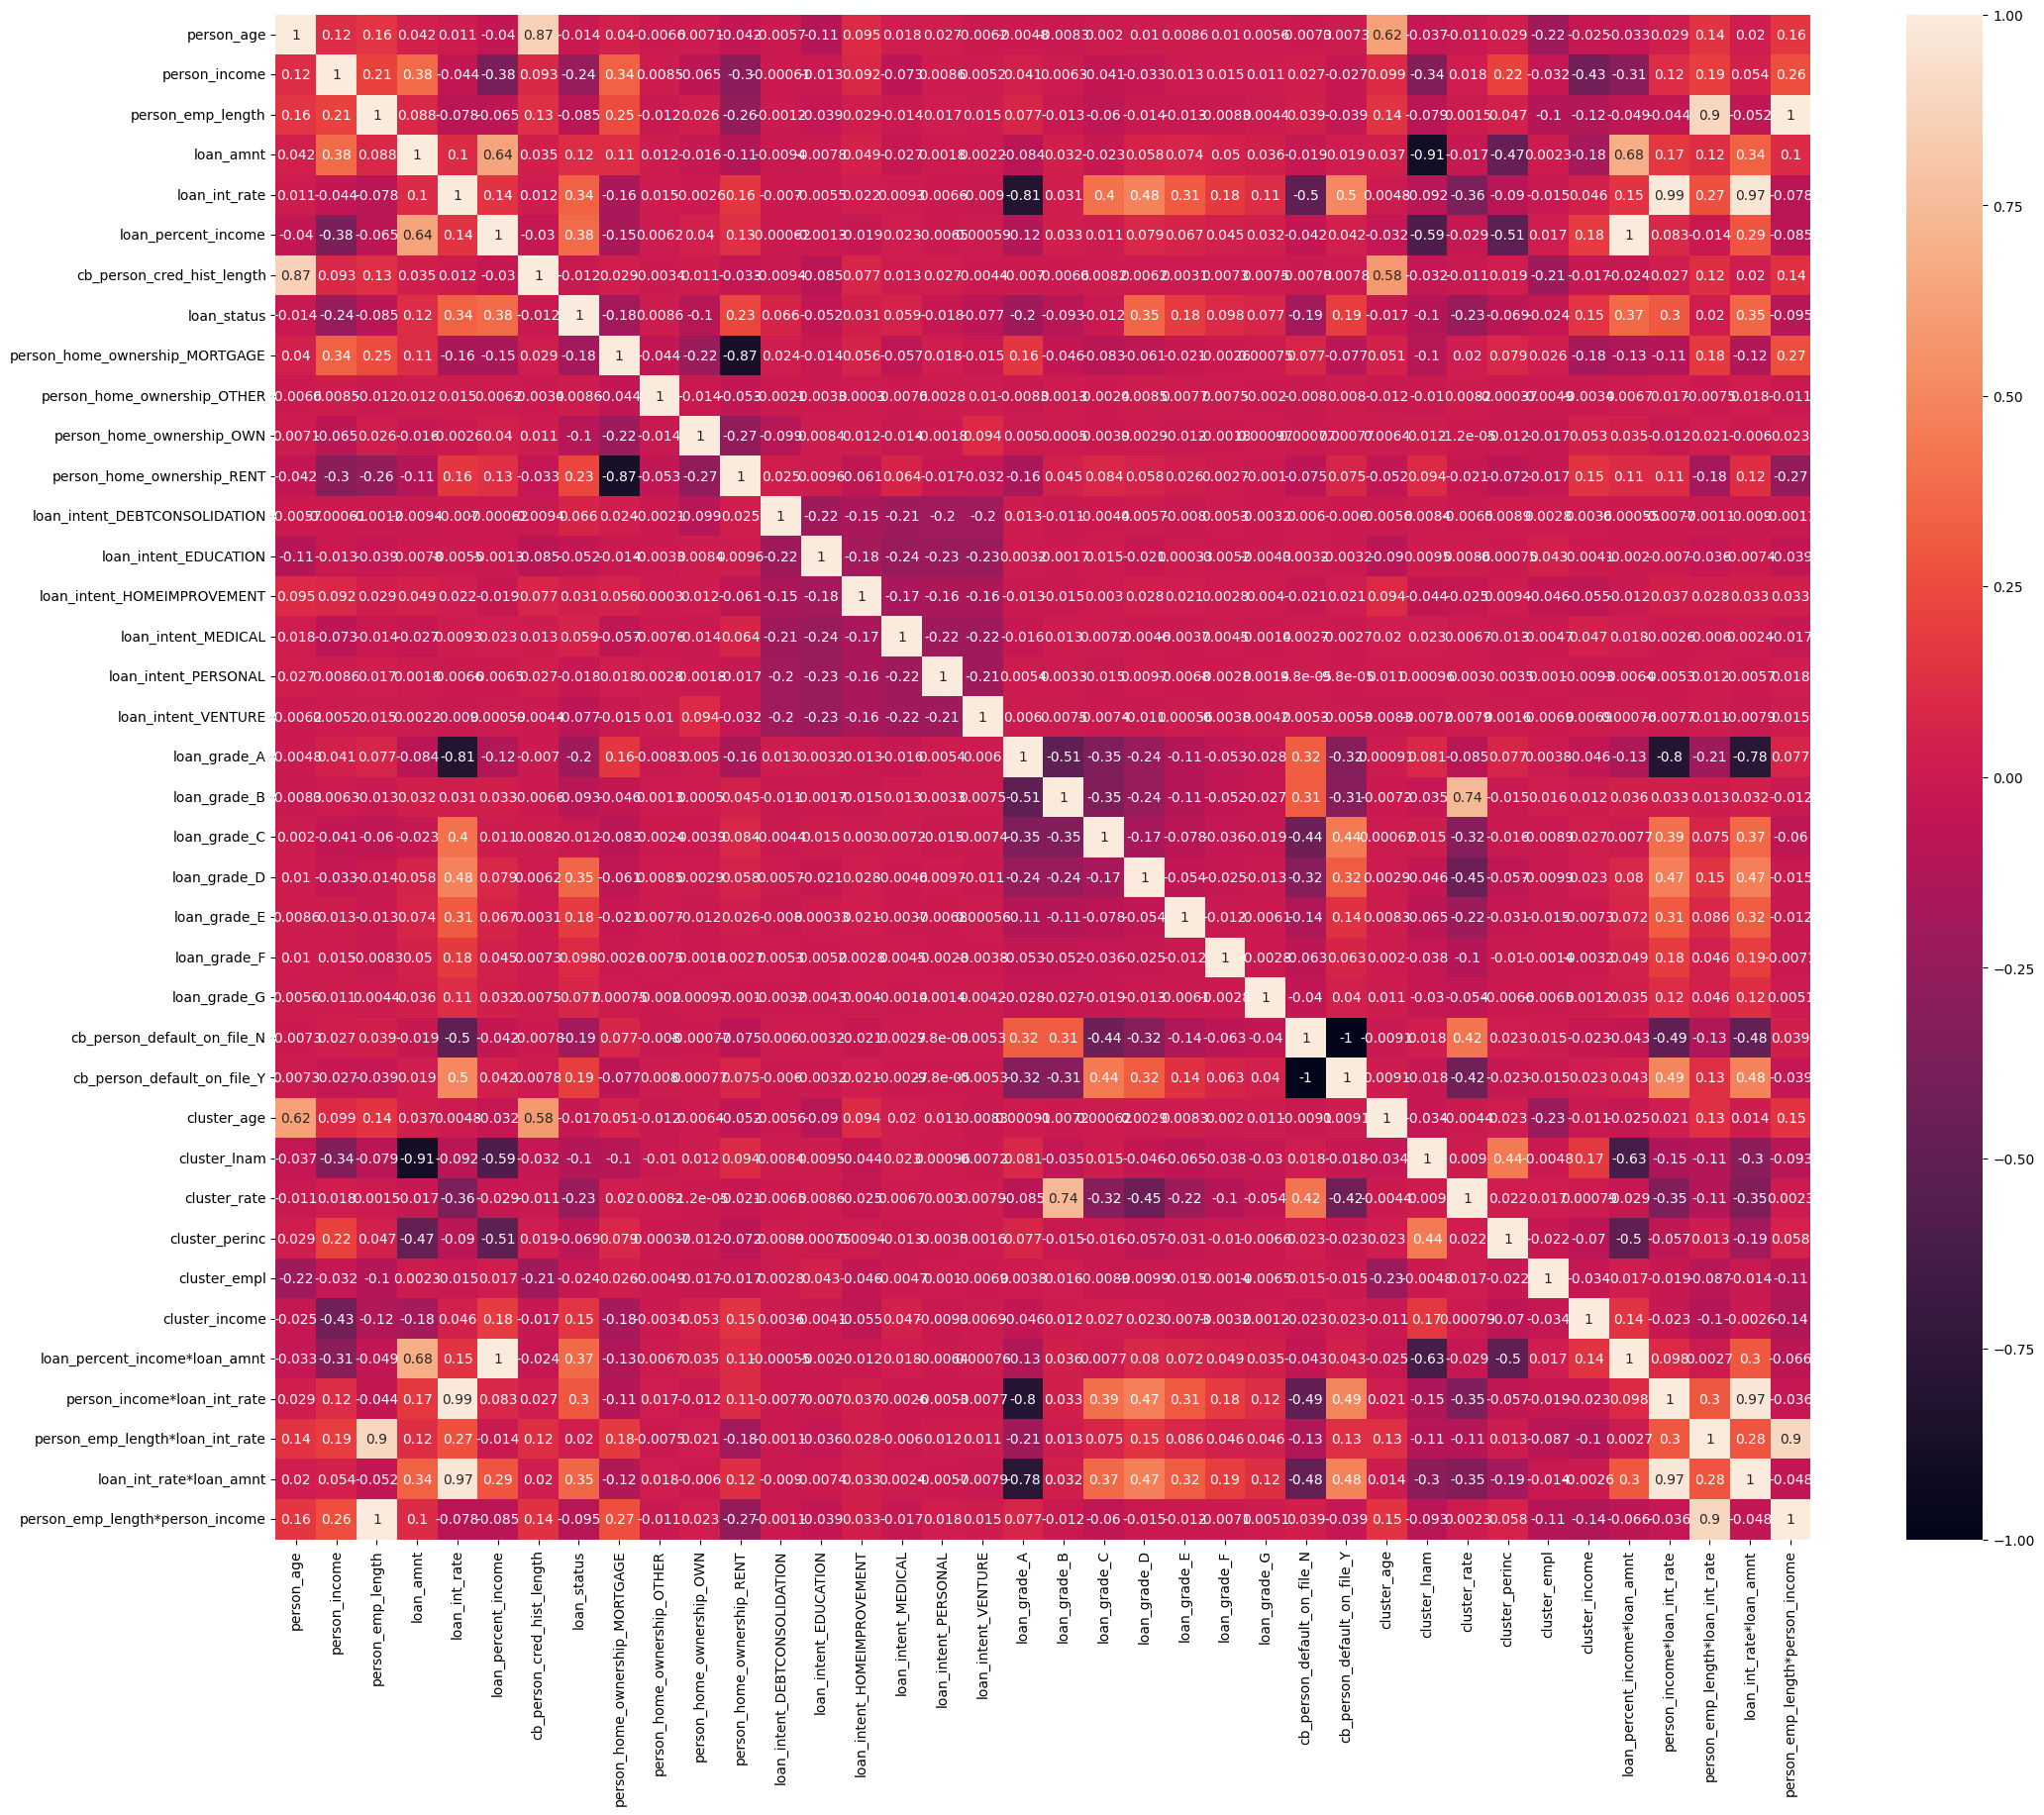

In [40]:
plt.figure(figsize=(25,20))
matrices=train_csv.corr()
sns.heatmap(matrices,annot=True)

In [41]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47473 entries, 0 to 32579
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       47473 non-null  float64
 1   person_income                    47473 non-null  float64
 2   person_emp_length                47473 non-null  float64
 3   loan_amnt                        47473 non-null  float64
 4   loan_int_rate                    47473 non-null  float64
 5   loan_percent_income              47473 non-null  float64
 6   cb_person_cred_hist_length       47473 non-null  float64
 7   loan_status                      47473 non-null  int64  
 8   person_home_ownership_MORTGAGE   47473 non-null  bool   
 9   person_home_ownership_OTHER      47473 non-null  bool   
 10  person_home_ownership_OWN        47473 non-null  bool   
 11  person_home_ownership_RENT       47473 non-null  bool   
 12  loan_intent_DEBTCONSOLI

In [42]:
for i in train_csv.columns:
    if train_csv[i].dtype=='int64':    
        train_csv[i]=train_csv[i].astype('int32')

In [43]:
for i in cont_var:
    if i=='loan_status':
        continue
    train_csv[i]=train_csv[i].astype('float32')    

In [44]:
y_values=train_csv.pop('loan_status')

In [45]:
from imblearn.combine import SMOTETomek

In [46]:
smote = SMOTETomek(random_state=42)
x_train, y_train = smote.fit_resample(train_csv, y_values)

In [47]:
print(x_train.shape)
x_train.describe()

(76848, 37)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,cluster_age,cluster_lnam,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income
count,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000,76848.000000
mean,27.309107,10.856844,4.460189,9.044821,11.782593,0.197601,5.588216,0.625494,0.731522,0.972504,0.971932,1.224690,0.843913,1.835865,127.869278,51.384991,106.789131,48.881779
std,5.568644,0.491363,3.887825,0.639476,3.337009,0.113808,3.719239,0.869373,0.696531,0.857658,0.852648,0.610666,0.880875,1.127143,36.710621,48.644405,32.030239,43.271545
min,20.000000,9.602450,0.000000,7.208601,5.420000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.330589,0.000000,39.070614,0.000000
25%,23.000000,10.491302,2.000000,8.610692,8.940000,0.103266,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.916962,98.896118,15.659830,81.440987,19.529204
50%,25.615625,10.838120,4.000000,9.121618,11.830000,0.172842,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.596767,128.597748,39.400002,107.545250,41.235943
75%,29.867157,11.158911,7.000000,9.536487,14.420000,0.280000,8.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.652788,155.385220,73.744143,129.718109,72.162903
max,57.000000,13.762111,26.000000,10.463132,23.219999,0.720000,27.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.122979,282.589783,423.540009,232.435501,327.900055


In [48]:
isolation_forest = IsolationForest(contamination='auto', random_state=42)
isolation_forest.fit(x_train) 
x_train['anomaly_scores'] = isolation_forest.decision_function(x_train)
x_train.head(30)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income,anomaly_scores
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,False,False,False,...,2,0,1,2,1.478946,120.221382,0.000000,99.959343,0.000000,0.029490
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,False,False,True,...,0,2,2,0,0.580601,145.957214,80.099998,110.728897,65.598747,0.000101
2,29.0,10.268166,8.0,8.699681,8.90,0.21,10.0,False,False,True,...,1,0,2,2,1.826933,91.386673,71.199997,77.427162,82.145325,-0.033521
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,False,False,False,...,2,0,0,0,1.596767,123.946098,155.539993,104.353401,156.187714,-0.005934
4,22.0,11.002116,2.0,8.699681,6.92,0.10,3.0,False,False,False,...,1,2,1,0,0.869968,76.134644,13.840000,60.201794,22.004232,0.057627
5,27.0,10.714440,2.0,9.105091,8.94,0.20,5.0,False,False,False,...,1,0,1,0,1.821018,95.787094,17.879999,81.399513,21.428881,0.070112
6,25.0,10.714440,9.0,9.392745,6.54,0.27,3.0,True,False,False,...,1,1,2,0,2.536041,70.072441,58.860001,61.428555,96.429962,0.027970
7,21.0,9.903538,0.0,7.824446,13.49,0.13,3.0,False,False,False,...,0,2,1,2,1.017178,133.598724,0.000000,105.551773,0.000000,-0.018161
8,37.0,11.150535,11.0,8.517393,14.84,0.07,11.0,False,False,False,...,0,2,0,0,0.596218,165.473923,163.240005,126.398117,122.655876,-0.045913
9,35.0,11.608245,0.0,9.615872,12.98,0.14,6.0,True,False,False,...,2,0,1,1,1.346222,150.675018,0.000000,124.814018,0.000000,-0.034408


In [49]:
scaler=RobustScaler()
columns_to_scale = [col for col in x_train.columns if col != 'anomaly_scores']
x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_train.head(30)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income,anomaly_scores
0,1.657800,-0.561689,-0.8,-0.455756,-0.062044,-0.016078,2.0,0.0,0.0,0.0,...,0.5,-0.5,0.0,0.5,-0.067876,-0.148283,-0.678324,-0.157133,-0.783451,0.029490
1,-0.526510,0.142305,0.4,-0.893630,0.277372,-0.581899,-0.4,0.0,0.0,1.0,...,-0.5,0.5,1.0,-0.5,-0.585408,0.307306,0.700705,0.065945,0.462875,0.000101
2,0.492835,-0.853726,0.8,-0.455756,-0.534672,0.210250,1.2,0.0,0.0,1.0,...,0.0,-0.5,1.0,0.5,0.132598,-0.658730,0.547480,-0.623858,0.777247,-0.033521
3,0.638456,0.476544,2.0,0.292858,-0.131387,-0.016078,0.2,0.0,0.0,0.0,...,0.5,-0.5,-1.0,-0.5,0.000000,-0.082346,1.999507,-0.066115,2.183996,-0.005934
4,-0.526510,0.245646,-0.4,-0.455756,-0.895985,-0.412153,-0.2,0.0,0.0,0.0,...,0.0,0.5,0.0,-0.5,-0.418705,-0.928730,-0.440050,-0.980660,-0.365388,0.057627
5,0.201594,-0.185258,-0.4,-0.017852,-0.527372,0.153668,0.2,0.0,0.0,0.0,...,0.0,-0.5,0.0,-0.5,0.129190,-0.580832,-0.370496,-0.541576,-0.376319,0.070112
6,-0.089648,-0.185258,1.0,0.292858,-0.965328,0.549743,-0.2,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.5,0.541111,-1.036046,0.335030,-0.955249,1.048644,0.027970
7,-0.672130,-1.399895,-0.8,-1.401144,0.302920,-0.242407,-0.2,0.0,0.0,0.0,...,-0.5,0.5,0.0,0.5,-0.333898,0.088530,-0.678324,-0.041292,-0.783451,-0.018161
8,1.657800,0.467960,1.4,-0.652655,0.549270,-0.581899,1.4,0.0,0.0,0.0,...,-0.5,0.5,-1.0,-0.5,-0.576411,0.652802,2.132073,0.390513,1.546916,-0.045913
9,1.366559,1.153556,-0.8,0.533870,0.209854,-0.185824,0.4,1.0,0.0,0.0,...,0.5,-0.5,0.0,0.0,-0.144337,0.390824,-0.678324,0.357701,-0.783451,-0.034408


In [50]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
76843    1
76844    1
76845    1
76846    1
76847    1
Name: loan_status, Length: 76848, dtype: int32

In [51]:
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3,random_state=42,shuffle=True)

In [52]:
print(x_train.shape)
print(x_cv.shape)

(53793, 38)
(23055, 38)


In [53]:
scorer=make_scorer(matthews_corrcoef)

In [54]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)}
    model=XGBClassifier(**params)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring='roc_auc')
    score=np.mean(score)
    return score

In [55]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

[I 2024-10-17 20:34:01,265] A new study created in memory with name: no-name-3b88557c-a2af-4320-8171-8c596e28eb2c
/tmp/ipykernel_22/627881382.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:34:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:34:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to 

In [56]:
{'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.05807354674468042, 'n_estimators': 379, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.7603836952091199, 'colsample_bytree': 0.6041174167035652}

{'booster': 'dart',
 'tree_method': 'gpu_hist',
 'learning_rate': 0.05807354674468042,
 'n_estimators': 379,
 'max_depth': 11,
 'min_child_weight': 1,
 'subsample': 0.7603836952091199,
 'colsample_bytree': 0.6041174167035652}

In [57]:
best_param=study.best_params
print(best_param)

{'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.030070524203742777, 'n_estimators': 470, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.9690824477068388, 'colsample_bytree': 0.6280889416294109}


**Chosen Param for Xgboost**

In [58]:
xgb_best_param={'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.05807354674468042, 'n_estimators': 379, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.7603836952091199, 'colsample_bytree': 0.6041174167035652}

In [59]:
from sklearn.metrics import accuracy_score

In [60]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [61]:
xgb_model=XGBClassifier(**xgb_best_param)
xgb_model.fit(x_train,y_train)
y_predict=xgb_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:18:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.9657774886141834


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:18:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Text(0, 0.5, 'recall')

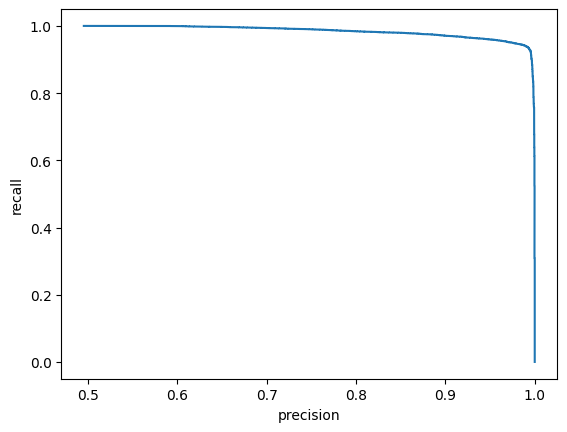

In [62]:
precision,recall,threshold=precision_recall_curve(y_cv,xgb_model.predict_proba(x_cv)[:,1])
plt.plot(precision,recall)
plt.xlabel('precision')
plt.ylabel('recall')

In [63]:
auc=average_precision_score(y_cv,xgb_model.predict_proba(x_cv)[:,1])
print(auc)

0.9916078343270955


<Axes: xlabel='importance', ylabel='feature'>

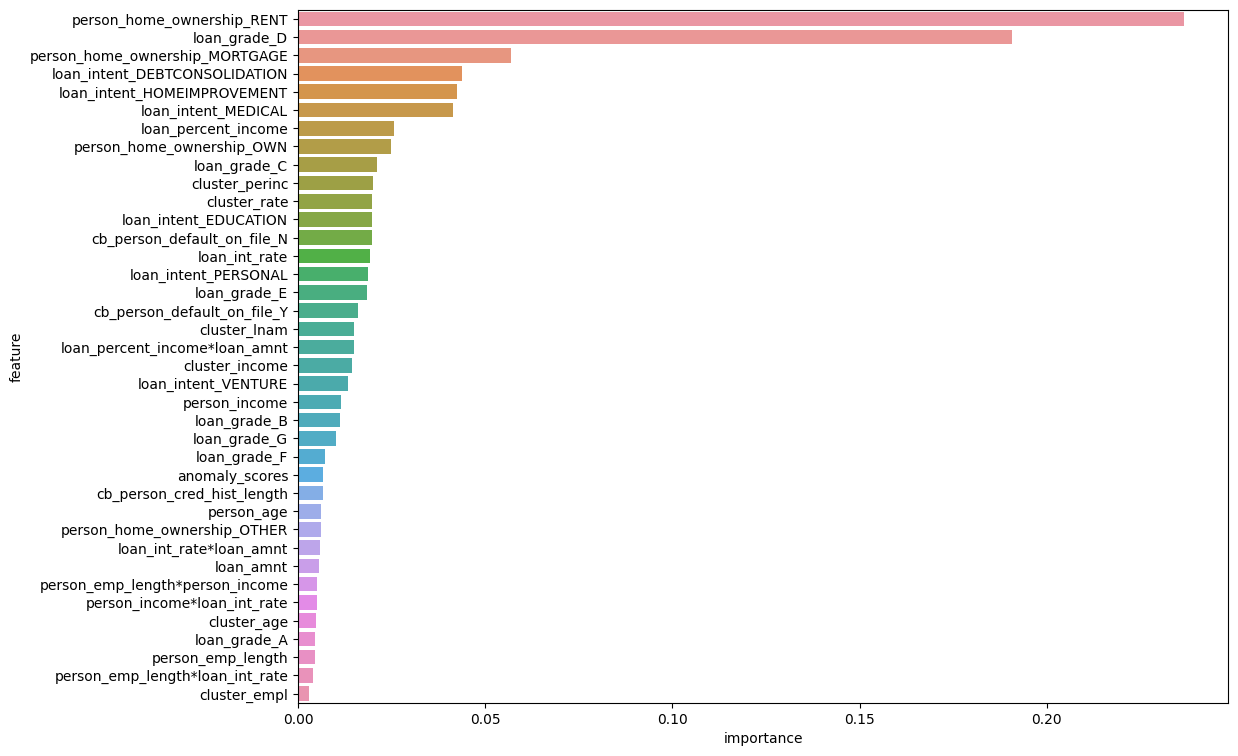

In [64]:
feature_name=xgb_model.feature_names_in_
feature_importance=xgb_model.feature_importances_
x_gbplot=pd.DataFrame({
    'feature':feature_name,
    'importance':feature_importance
})
x_gbplot=x_gbplot.sort_values(by='importance',ascending=False)
plt.figure(figsize=(12,9))
sns.barplot(x=x_gbplot['importance'],y=x_gbplot['feature'],data=x_gbplot)

In [65]:
from sklearn.feature_selection import RFE

In [66]:
refined_xgbmodel=RFE(estimator=xgb_model,n_features_to_select=30)
refined_xgbmodel.fit(x_train,y_train)
y_predict=refined_xgbmodel.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:18:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:19:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:19:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

0.9651702450661461


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:22:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [67]:
isolation_forest.fit(train_csv) 
train_csv['anomaly_scores'] = isolation_forest.decision_function(train_csv)
train_csv.head(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income,anomaly_scores
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,False,False,False,...,2,0,1,2,1.478946,120.221382,0.000000,99.959343,0.000000,0.016980
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,False,False,True,...,0,2,2,0,0.580601,145.957214,80.099998,110.728897,65.598747,-0.010968
2,29.0,10.268166,8.0,8.699681,8.90,0.21,10.0,False,False,True,...,1,0,2,2,1.826933,91.386673,71.199997,77.427162,82.145325,-0.022304
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,False,False,False,...,2,0,0,0,1.596767,123.946098,155.539993,104.353401,156.187714,0.001520
4,22.0,11.002116,2.0,8.699681,6.92,0.10,3.0,False,False,False,...,1,2,1,0,0.869968,76.134644,13.840000,60.201794,22.004232,0.060591
5,27.0,10.714440,2.0,9.105091,8.94,0.20,5.0,False,False,False,...,1,0,1,0,1.821018,95.787094,17.879999,81.399513,21.428881,0.065805
6,25.0,10.714440,9.0,9.392745,6.54,0.27,3.0,True,False,False,...,1,1,2,0,2.536041,70.072441,58.860001,61.428555,96.429962,0.037274
7,21.0,9.903538,0.0,7.824446,13.49,0.13,3.0,False,False,False,...,0,2,1,2,1.017178,133.598724,0.000000,105.551773,0.000000,-0.028089
8,37.0,11.150535,11.0,8.517393,14.84,0.07,11.0,False,False,False,...,0,2,0,0,0.596218,165.473923,163.240005,126.398117,122.655876,-0.061865
9,35.0,11.608245,0.0,9.615872,12.98,0.14,6.0,True,False,False,...,2,0,1,1,1.346222,150.675018,0.000000,124.814018,0.000000,-0.051884


In [68]:
columns_to_scale = [col for col in train_csv.columns if col != 'anomaly_scores']
train_csv[columns_to_scale] = scaler.transform(train_csv[columns_to_scale])
train_csv.head(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income,anomaly_scores
0,1.657800,-0.561689,-0.8,-0.455756,-0.062044,-0.016078,2.0,0.0,0.0,0.0,...,0.5,-0.5,0.0,0.5,-0.067876,-0.148283,-0.678324,-0.157133,-0.783451,0.016980
1,-0.526510,0.142305,0.4,-0.893630,0.277372,-0.581899,-0.4,0.0,0.0,1.0,...,-0.5,0.5,1.0,-0.5,-0.585408,0.307306,0.700705,0.065945,0.462875,-0.010968
2,0.492835,-0.853726,0.8,-0.455756,-0.534672,0.210250,1.2,0.0,0.0,1.0,...,0.0,-0.5,1.0,0.5,0.132598,-0.658730,0.547480,-0.623858,0.777247,-0.022304
3,0.638456,0.476544,2.0,0.292858,-0.131387,-0.016078,0.2,0.0,0.0,0.0,...,0.5,-0.5,-1.0,-0.5,0.000000,-0.082346,1.999507,-0.066115,2.183996,0.001520
4,-0.526510,0.245646,-0.4,-0.455756,-0.895985,-0.412153,-0.2,0.0,0.0,0.0,...,0.0,0.5,0.0,-0.5,-0.418705,-0.928730,-0.440050,-0.980660,-0.365388,0.060591
5,0.201594,-0.185258,-0.4,-0.017852,-0.527372,0.153668,0.2,0.0,0.0,0.0,...,0.0,-0.5,0.0,-0.5,0.129190,-0.580832,-0.370496,-0.541576,-0.376319,0.065805
6,-0.089648,-0.185258,1.0,0.292858,-0.965328,0.549743,-0.2,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.5,0.541111,-1.036046,0.335030,-0.955249,1.048644,0.037274
7,-0.672130,-1.399895,-0.8,-1.401144,0.302920,-0.242407,-0.2,0.0,0.0,0.0,...,-0.5,0.5,0.0,0.5,-0.333898,0.088530,-0.678324,-0.041292,-0.783451,-0.028089
8,1.657800,0.467960,1.4,-0.652655,0.549270,-0.581899,1.4,0.0,0.0,0.0,...,-0.5,0.5,-1.0,-0.5,-0.576411,0.652802,2.132073,0.390513,1.546916,-0.061865
9,1.366559,1.153556,-0.8,0.533870,0.209854,-0.185824,0.4,1.0,0.0,0.0,...,0.5,-0.5,0.0,0.0,-0.144337,0.390824,-0.678324,0.357701,-0.783451,-0.051884


In [69]:
y_predict=xgb_model.predict(train_csv)
accuracy=accuracy_score(y_values,y_predict)
print(accuracy)

0.9730794346259979


In [70]:
y_predict=refined_xgbmodel.predict(train_csv)
accuracy=accuracy_score(y_values,y_predict)
print(accuracy)

0.9708887156910244


In [71]:
auc=average_precision_score(y_values,xgb_model.predict_proba(train_csv)[:,1])
print(auc)

0.9651140374012275


In [72]:
from sklearn.metrics import roc_auc_score

In [73]:
auc_roc=roc_auc_score(y_values,xgb_model.predict_proba(train_csv)[:,1])
print(auc_roc)

0.9852157699046934


In [74]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [75]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 200, 500),
        'depth': trial.suggest_int('depth', 5, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 10.0),
    }
    model = CatBoostClassifier(**param,verbose=0)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring='roc_auc')
    score=np.mean(score)
    return score


In [76]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

[I 2024-10-17 22:22:27,657] A new study created in memory with name: no-name-4f518f03-0871-4713-9e44-660c90b1e68c
/tmp/ipykernel_22/4012072090.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
/tmp/ipykernel_22/4012072090.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
/tmp/ipykernel_22/4012072090.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temper

In [77]:
best_param=study.best_params
print(best_param)

{'iterations': 475, 'depth': 6, 'learning_rate': 0.08846416905493806, 'l2_leaf_reg': 6.57581973431211e-08, 'border_count': 245, 'bagging_temperature': 0.15220730147164724, 'random_strength': 4.043950582067399}


In [78]:
cat_param={'iterations': 448, 'depth': 9, 'learning_rate': 0.08791101287939408, 'l2_leaf_reg': 0.936621571264189, 'border_count': 138, 'bagging_temperature': 0.22044167195484043, 'random_strength': 2.0271697933395414}

In [79]:
cat_model=CatBoostClassifier(**cat_param)
cat_model.fit(x_train,y_train)
y_predict=cat_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

0:	learn: 0.5947759	total: 31.4ms	remaining: 14s
1:	learn: 0.5079135	total: 66.6ms	remaining: 14.9s
2:	learn: 0.4423517	total: 101ms	remaining: 15s
3:	learn: 0.4000500	total: 134ms	remaining: 14.9s
4:	learn: 0.3529117	total: 167ms	remaining: 14.8s
5:	learn: 0.3299754	total: 202ms	remaining: 14.9s
6:	learn: 0.3139131	total: 235ms	remaining: 14.8s
7:	learn: 0.2943510	total: 270ms	remaining: 14.8s
8:	learn: 0.2771463	total: 304ms	remaining: 14.8s
9:	learn: 0.2517984	total: 336ms	remaining: 14.7s
10:	learn: 0.2425624	total: 370ms	remaining: 14.7s
11:	learn: 0.2350141	total: 403ms	remaining: 14.7s
12:	learn: 0.2279109	total: 438ms	remaining: 14.6s
13:	learn: 0.2224244	total: 471ms	remaining: 14.6s
14:	learn: 0.2182385	total: 504ms	remaining: 14.6s
15:	learn: 0.2137126	total: 537ms	remaining: 14.5s
16:	learn: 0.2071775	total: 571ms	remaining: 14.5s
17:	learn: 0.2041619	total: 603ms	remaining: 14.4s
18:	learn: 0.1984789	total: 636ms	remaining: 14.4s
19:	learn: 0.1917013	total: 671ms	remaining

In [80]:
auc=average_precision_score(y_cv,cat_model.predict_proba(x_cv)[:,1])
print(auc)

0.990617361081801


In [81]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'verbosity':-1,
    }
    model = LGBMClassifier(**param,verbose=0)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring='roc_auc')
    score=np.mean(score)
    return score 


In [82]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

[I 2024-10-17 23:02:18,942] A new study created in memory with name: no-name-61179a58-343f-4021-86d4-84856ae36c6a
/tmp/ipykernel_22/1490707404.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipykernel_22/1490707404.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipykernel_22/1490707404.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6

In [83]:
lgb_param=study.best_params
print(lgb_param)

{'num_leaves': 56, 'max_depth': 8, 'learning_rate': 0.07732096281351501, 'n_estimators': 417, 'subsample': 0.9176100642954482, 'colsample_bytree': 0.7088102319110117, 'min_child_samples': 33, 'reg_alpha': 0.443436784263929, 'reg_lambda': 4.516516655136673e-06}


In [84]:
lgb_param={'num_leaves': 134, 'max_depth': 7, 'learning_rate': 0.08018598484643658, 'n_estimators': 453, 'subsample': 0.9180886301236619, 'colsample_bytree': 0.6376161711751216, 'min_child_samples': 29, 'reg_alpha': 0.339289989958177, 'reg_lambda': 0.001167347630583991}

In [85]:
lgb_model=LGBMClassifier(**lgb_param)
lgb_model.fit(x_train,y_train)
y_predict=lgb_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

[LightGBM] [Info] Number of positive: 27007, number of negative: 26786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3304
[LightGBM] [Info] Number of data points in the train set: 53793, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502054 -> initscore=0.008217
[LightGBM] [Info] Start training from score 0.008217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [86]:
auc=average_precision_score(y_cv,lgb_model.predict_proba(x_cv)[:,1])
print(auc)

0.9916186659954647


In [87]:
from sklearn.ensemble import VotingClassifier

In [88]:
voting_model = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('lgbm', lgb_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  
)

In [89]:
voting_model.fit(x_train,y_train)
y_predict=voting_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

0:	learn: 0.5947759	total: 30.9ms	remaining: 13.8s
1:	learn: 0.5079135	total: 62.7ms	remaining: 14s
2:	learn: 0.4423517	total: 95.3ms	remaining: 14.1s
3:	learn: 0.4000500	total: 127ms	remaining: 14.1s
4:	learn: 0.3529117	total: 157ms	remaining: 13.9s
5:	learn: 0.3299754	total: 189ms	remaining: 14s
6:	learn: 0.3139131	total: 223ms	remaining: 14.1s
7:	learn: 0.2943510	total: 256ms	remaining: 14.1s
8:	learn: 0.2771463	total: 289ms	remaining: 14.1s
9:	learn: 0.2517984	total: 319ms	remaining: 13.9s
10:	learn: 0.2425624	total: 351ms	remaining: 13.9s
11:	learn: 0.2350141	total: 382ms	remaining: 13.9s
12:	learn: 0.2279109	total: 413ms	remaining: 13.8s
13:	learn: 0.2224244	total: 444ms	remaining: 13.7s
14:	learn: 0.2182385	total: 476ms	remaining: 13.7s
15:	learn: 0.2137126	total: 510ms	remaining: 13.8s
16:	learn: 0.2071775	total: 542ms	remaining: 13.7s
17:	learn: 0.2041619	total: 572ms	remaining: 13.7s
18:	learn: 0.1984789	total: 604ms	remaining: 13.6s
19:	learn: 0.1917013	total: 636ms	remainin

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:23:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:23:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.9652136196052917


In [90]:
auc=average_precision_score(y_cv,voting_model.predict_proba(x_cv)[:,1])
print(auc)

0.9917736118037385


In [91]:
test_csv='/kaggle/input/playground-series-s4e10/test.csv'

In [92]:
test_csv=pd.read_csv(test_csv)
test_csv

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
39094,97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
39095,97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25
39096,97741,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4


In [93]:
test_csv.drop_duplicates(inplace=True)

In [94]:
test_csv.shape

(39098, 12)

In [95]:
id=test_csv.pop('id')

In [96]:
test_csv['person_income']=np.log(test_csv['person_income']+1)
test_csv['loan_amnt']=np.log(test_csv['loan_amnt']+1)

In [97]:
test_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,11.141876,RENT,3.0,HOMEIMPROVEMENT,F,10.126671,15.76,0.36,N,2
1,26,11.472114,MORTGAGE,6.0,PERSONAL,C,9.210440,12.68,0.10,Y,4
2,26,10.308986,RENT,5.0,VENTURE,E,8.294300,17.19,0.13,Y,2
3,33,10.819798,RENT,4.0,DEBTCONSOLIDATION,A,8.853808,8.90,0.14,N,7
4,26,11.532738,MORTGAGE,8.0,HOMEIMPROVEMENT,D,9.615872,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...
39093,22,10.348205,MORTGAGE,2.0,DEBTCONSOLIDATION,B,8.006701,10.37,0.10,N,4
39094,22,10.778977,MORTGAGE,6.0,EDUCATION,A,8.853808,6.03,0.15,N,3
39095,51,11.002117,MORTGAGE,0.0,PERSONAL,A,9.615872,7.51,0.25,N,25
39096,22,10.491302,MORTGAGE,4.0,PERSONAL,D,9.546884,15.62,0.39,Y,4


In [98]:
test_csv=pd.get_dummies(test_csv)

In [99]:
cluster_tage=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='person_age',is_train=False,k_scaled=scale_age,k_meansd=kmeans_age)
cluster_tincome=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='person_income',is_train=False,k_scaled=scale_income,k_meansd=kmeans_income)
cluster_templ=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='person_emp_length',is_train=False,k_scaled=scale_empl,k_meansd=kmeans_empl)
cluster_tlnam=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='loan_amnt',is_train=False,k_scaled=scale_lnam,k_meansd=kmeans_lnam)
cluster_trate=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='loan_int_rate',is_train=False,k_scaled=scale_rate,k_meansd=kmeans_rate)
cluster_tperinc=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='loan_percent_income',is_train=False,k_scaled=scale_perinc,k_meansd=kmeans_perinc)

In [100]:
test_csv['cluster_age']=cluster_tage
test_csv['cluster_lnam']=cluster_tlnam
test_csv['cluster_rate']=cluster_trate
test_csv['cluster_perinc']=cluster_tperinc
test_csv['cluster_empl']=cluster_templ
test_csv['cluster_income']=cluster_tincome
test_csv

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,cluster_age,cluster_lnam,cluster_rate,cluster_perinc,cluster_empl,cluster_income
0,23,11.141876,3.0,10.126671,15.76,0.36,2,False,False,False,...,True,False,True,False,0,0,0,1,1,0
1,26,11.472114,6.0,9.210440,12.68,0.10,4,True,False,False,...,False,False,False,True,0,1,2,2,2,1
2,26,10.308986,5.0,8.294300,17.19,0.13,2,False,False,False,...,False,False,False,True,0,2,0,2,2,2
3,33,10.819798,4.0,8.853808,8.90,0.14,7,False,False,False,...,False,False,True,False,2,1,1,0,1,0
4,26,11.532738,8.0,9.615872,16.32,0.15,4,True,False,False,...,False,False,False,True,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,22,10.348205,2.0,8.006701,10.37,0.10,4,True,False,False,...,False,False,True,False,0,2,2,2,1,2
39094,22,10.778977,6.0,8.853808,6.03,0.15,3,True,False,False,...,False,False,True,False,0,1,1,0,2,0
39095,51,11.002117,0.0,9.615872,7.51,0.25,25,True,False,False,...,False,False,True,False,1,0,1,0,1,0
39096,22,10.491302,4.0,9.546884,15.62,0.39,4,True,False,False,...,False,False,False,True,0,0,0,1,1,2


In [101]:
test_csv['loan_percent_income*loan_amnt']=test_csv['loan_percent_income']*test_csv['loan_amnt']
test_csv['person_income*loan_int_rate']=test_csv['person_income']*test_csv['loan_int_rate']
test_csv['person_emp_length*loan_int_rate']=test_csv['person_emp_length']*test_csv['loan_int_rate']
test_csv['loan_int_rate*loan_amnt']=test_csv['loan_int_rate']*test_csv['loan_amnt']
test_csv['person_emp_length*person_income']=test_csv['person_emp_length']*test_csv['person_income']

In [102]:
for i in cont_var:
    if i=='loan_status':
        continue
    test_csv[i]=test_csv[i].astype('float32')    

In [103]:
test_csv

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_lnam,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income
0,23.0,11.141876,3.0,10.126671,15.760000,0.36,2.0,False,False,False,...,0,0,1,1,0,3.645602,175.595963,47.279999,159.596344,33.425629
1,26.0,11.472114,6.0,9.210441,12.680000,0.10,4.0,True,False,False,...,1,2,2,2,1,0.921044,145.466400,76.080002,116.788383,68.832680
2,26.0,10.308986,5.0,8.294300,17.190001,0.13,2.0,False,False,False,...,2,0,2,2,2,1.078259,177.211472,85.949997,142.579010,51.544930
3,33.0,10.819798,4.0,8.853808,8.900000,0.14,7.0,False,False,False,...,1,1,0,1,0,1.239533,96.296204,35.599998,78.798897,43.279194
4,26.0,11.532738,8.0,9.615872,16.320000,0.15,4.0,True,False,False,...,0,0,0,2,1,1.442381,188.214279,130.559998,156.931030,92.261902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,22.0,10.348206,2.0,8.006701,10.370000,0.10,4.0,True,False,False,...,2,2,2,1,2,0.800670,107.310890,20.740000,83.029488,20.696411
39094,22.0,10.778977,6.0,8.853808,6.030000,0.15,3.0,True,False,False,...,1,1,0,2,0,1.328071,64.997231,36.180000,53.388462,64.673866
39095,51.0,11.002116,0.0,9.615872,7.510000,0.25,25.0,True,False,False,...,0,1,0,1,0,2.403968,82.625893,0.000000,72.215202,0.000000
39096,22.0,10.491302,4.0,9.546884,15.620000,0.39,4.0,True,False,False,...,0,0,1,1,2,3.723285,163.874130,62.480000,149.122330,41.965206


In [104]:
isolation_forest.fit(test_csv) 
test_csv['anomaly_scores'] = isolation_forest.decision_function(test_csv)
test_csv.head(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income,anomaly_scores
0,23.0,11.141876,3.0,10.126671,15.760000,0.36,2.0,False,False,False,...,0,1,1,0,3.645602,175.595963,47.279999,159.596344,33.425629,-0.029477
1,26.0,11.472114,6.0,9.210441,12.680000,0.10,4.0,True,False,False,...,2,2,2,1,0.921044,145.466400,76.080002,116.788383,68.832680,-0.002224
2,26.0,10.308986,5.0,8.294300,17.190001,0.13,2.0,False,False,False,...,0,2,2,2,1.078259,177.211472,85.949997,142.579010,51.544930,-0.048264
3,33.0,10.819798,4.0,8.853808,8.900000,0.14,7.0,False,False,False,...,1,0,1,0,1.239533,96.296204,35.599998,78.798897,43.279194,0.044282
4,26.0,11.532738,8.0,9.615872,16.320000,0.15,4.0,True,False,False,...,0,0,2,1,1.442381,188.214279,130.559998,156.931030,92.261902,-0.063584
5,23.0,11.097425,5.0,9.998843,14.090000,0.33,2.0,False,False,False,...,0,1,2,0,3.299618,156.362717,70.449997,140.883698,55.487125,-0.024233
6,26.0,11.225257,10.0,8.987322,10.620000,0.11,4.0,False,False,True,...,2,2,0,0,0.988605,119.212227,106.199997,95.445358,112.252563,-0.003580
7,23.0,10.915107,6.0,8.740497,6.760000,0.12,2.0,True,False,False,...,1,2,2,0,1.048860,73.786118,40.560001,59.085758,65.490639,0.076690
8,32.0,10.279352,0.0,8.881975,13.110000,0.26,6.0,False,False,False,...,0,0,1,2,2.309314,134.762314,0.000000,116.442696,0.000000,-0.018256
9,22.0,11.407576,4.0,9.210441,13.490000,0.11,3.0,False,False,False,...,0,2,1,1,1.013148,153.888199,53.959999,124.248840,45.630302,0.006588


In [105]:
columns_to_scale=[col for col in test_csv.columns if col!='anomaly_scores']
test_csv[columns_to_scale] = scaler.transform(test_csv[columns_to_scale])
test_csv.head(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cluster_rate,cluster_perinc,cluster_empl,cluster_income,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,loan_int_rate*loan_amnt,person_emp_length*person_income,anomaly_scores
0,-0.380889,0.454991,-0.2,1.085610,0.717153,1.058982,-0.4,0.0,0.0,0.0,...,-0.5,0.0,0.0,-0.5,1.180323,0.831987,0.135665,1.078173,-0.148390,-0.029477
1,0.055973,0.949647,0.4,0.095942,0.155110,-0.412153,0.0,1.0,0.0,0.0,...,0.5,0.5,1.0,0.0,-0.389280,0.298618,0.631496,0.191460,0.524317,-0.002224
2,0.055973,-0.792582,0.2,-0.893630,0.978102,-0.242407,-0.4,0.0,0.0,0.0,...,-0.5,0.5,1.0,0.5,-0.298710,0.860586,0.801421,0.725680,0.195863,-0.048264
3,1.075318,-0.027444,0.0,-0.289276,-0.534672,-0.185824,0.6,0.0,0.0,0.0,...,0.0,-0.5,0.0,-0.5,-0.205800,-0.571819,-0.065422,-0.595445,0.038820,0.044282
4,0.055973,1.040455,0.8,0.533870,0.819343,-0.129242,0.0,1.0,0.0,0.0,...,-0.5,-0.5,1.0,0.0,-0.088941,1.055363,1.569443,1.022964,0.969454,-0.063584
5,-0.380889,0.388408,0.2,0.947537,0.412409,0.889235,-0.4,0.0,0.0,0.0,...,-0.5,0.0,1.0,-0.5,0.981004,0.491510,0.534568,0.690564,0.270762,-0.024233
6,0.055973,0.579885,1.2,-0.145061,-0.220803,-0.355571,0.0,0.0,0.0,1.0,...,0.5,0.5,-1.0,-0.5,-0.350359,-0.166147,1.150052,-0.250634,1.349261,-0.003580
7,-0.380889,0.115316,0.4,-0.411670,-0.925182,-0.298989,-0.4,1.0,0.0,0.0,...,0.0,0.5,1.0,-0.5,-0.315646,-0.970305,0.019971,-1.003778,0.460821,0.076690
8,0.929697,-0.836969,-0.8,-0.258851,0.233577,0.493161,0.4,0.0,0.0,0.0,...,-0.5,-0.5,0.0,0.5,0.410495,0.109128,-0.678324,0.184299,-0.783451,-0.018256
9,-0.526510,0.852977,0.0,0.095942,0.302920,-0.355571,-0.2,0.0,0.0,0.0,...,-0.5,0.5,0.0,0.0,-0.336219,0.447705,0.250670,0.345994,0.083489,0.006588


In [106]:
y_test=voting_model.predict(test_csv)

In [107]:
y_test

array([1, 0, 0, ..., 0, 0, 1], dtype=int32)

In [108]:
subnit_df=pd.DataFrame({
    'id':id,
    'loan_status':y_test
})

In [109]:
subnit_df

,id,loan_status
0,58645,1
1,58646,0
2,58647,0
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0


In [110]:
subnit_df.to_csv('my_submission.csv',index=False)